In [26]:
require(gdata)
library(caret)
library(ggplot2)
library(grid)
library(gridExtra)
library(reshape)

## Common Funcitons

In [35]:
set.seed(24287)

bindModel <- function(yLabel, xFeatures=NULL, featureSet=NULL){
    # Automates the creation of feature model to be passed into an Classifier or Predictive Model
    print (yLabel)
    if (is.null(xFeatures)){
        xFeatures <- featureSet[featureSet != yLabel]
    }   
    return (as.formula(paste(yLabel, "~", paste(xFeatures, collapse = '+ '))))
}

stratifiedSampling <- function(dataIN, sample_on_col, trainPrcnt){
  trainIndices <- createDataPartition(y=dataIN[[sample_on_col]], p=trainPrcnt, list=FALSE)
  trainData <- dataIN[trainIndices,]
  testData <- dataIN[-trainIndices,]
  
  stopifnot(nrow(trainData) + nrow(testData) == nrow(dataIN))
  return (list(trainData, testData))
}

### ii. Download the credit card default data set from the UCI machine learning repository. https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients Load the data into R.


In [3]:
dataDir <- "/Users/sam/All-Program/App-DataSet/Study/Data-Prep-Analysis/default_of_credit_card_clients.xls"
credit.data <- read.xls (dataDir, sheet = 1, skip=1, header = TRUE)
head(credit.data)
# data1<-read.xls(file="default_of_credit_card_clients.xlsx", sheet = 1, skip = 1, header = TRUE)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [4]:
# Remove the ID column:
credit.data <- subset(credit.data, select=-c(ID))
head(credit.data)

# Change the label column name
colnames(credit.data)[24] <- "default"

LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
20000,2,2,1,24,2,2,-1,-1,-2,⋯,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,-1,2,0,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,0,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,0,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,-1,0,-1,0,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,0,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


### iii. Identify all the relevant categorical, numeric, and logical variables.

It seems that [sex, education, marriage, age], [PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6] are nominal
PAY_0 : September
PAY_2 : August
PAY_3 : July
PAY_4 : June
PAY_5 : May
PAY_6 : April
 -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 

In [5]:
uniqueCount <- function (feature){
    return (length(unlist(unique(credit.data[feature]))))
  } 
sapply(colnames(credit.data), FUN=uniqueCount)

LIMIT_BAL       SEX EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2     PAY_3 
       81         2         7         4        56        11        11        11 
    PAY_4     PAY_5     PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 
       11        10        10     22723     22346     22026     21548     21010 
BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6   default 
    20604      7943      7899      7518      6937      6897      6939         2

In [6]:
numericCols <- names(which(sapply(credit.data, is.numeric)))
nominalCols <- names(which(sapply(credit.data, is.factor)))
print (nrow(credit.data))
print (ncol(credit.data))
print (numericCols)
print (nominalCols)

# Check if data is missing
which(is.na(credit.data))

[1] 30000
[1] 24
 [1] "LIMIT_BAL" "SEX"       "EDUCATION" "MARRIAGE"  "AGE"       "PAY_0"    
 [7] "PAY_2"     "PAY_3"     "PAY_4"     "PAY_5"     "PAY_6"     "BILL_AMT1"
[13] "BILL_AMT2" "BILL_AMT3" "BILL_AMT4" "BILL_AMT5" "BILL_AMT6" "PAY_AMT1" 
[19] "PAY_AMT2"  "PAY_AMT3"  "PAY_AMT4"  "PAY_AMT5"  "PAY_AMT6"  "default"  
character(0)


integer(0)

In [7]:
# Chanbging the datatypes
changeDataType <- function(feature){
    print (feature)
    credit.data[[feature]] <- as.factor(as.character(credit.data[[feature]])) 
}

credit.data$SEX <- as.factor(as.character(credit.data$SEX)) 
credit.data$EDUCATION <- as.factor(as.character(credit.data$EDUCATION)) 
credit.data$MARRIAGE <- as.factor(as.character(credit.data$MARRIAGE)) 
credit.data$PAY_0 <- as.factor(as.character(credit.data$PAY_0)) 
credit.data$PAY_2 <- as.factor(as.character(credit.data$PAY_2)) 
credit.data$PAY_3 <- as.factor(as.character(credit.data$PAY_3)) 
credit.data$PAY_4 <- as.factor(as.character(credit.data$PAY_4)) 
credit.data$PAY_5 <- as.factor(as.character(credit.data$PAY_5))
credit.data$PAY_6 <- as.factor(as.character(credit.data$PAY_6)) 

# credit.nominalCol <- c('SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6')
# sapply(credit.nominalCol, FUN=changeDataType)

In [8]:
credit.numericCols <- names(which(sapply(credit.data, is.numeric)))
credit.nominalCols <- names(which(sapply(credit.data, is.factor)))
length(credit.numericCols)
length(credit.nominalCols)

[1] 15

[1] 9

### iv. Perform all required EDA on this data set.

In [9]:
# ScatterPlot
# We select a small sample to plot
# plot(credit.data)

set.seed(24287)
samplePrcntg <- 0.10
credit.sampleIndices <- createDataPartition(y = credit.data$default, p=samplePrcntg, list=FALSE)
credit.sample <- credit.data[credit.sampleIndices , ]

head(credit.sample)
nrow(credit.sample)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
9,140000,2,3,1,28,0,0,2,0,0,⋯,12211,11793,3719,3329,0,432,1000,1000,1000,0
16,50000,2,3,3,23,1,2,0,0,0,⋯,28771,29531,30211,0,1500,1100,1200,1300,1100,0
24,450000,2,1,1,40,-2,-2,-2,-2,-2,⋯,560,0,0,19428,1473,560,0,0,1128,1
26,50000,1,3,2,23,0,0,0,0,0,⋯,28967,29829,30046,1973,1426,1001,1432,1062,997,0
27,60000,1,1,2,27,1,-2,-1,-1,-1,⋯,-57,127,-189,0,1000,0,500,0,1000,1
42,70000,2,1,2,25,0,0,0,0,0,⋯,63699,64718,65970,3000,4500,4042,2500,2800,2500,0


[1] 3000

--> Scatter Plot

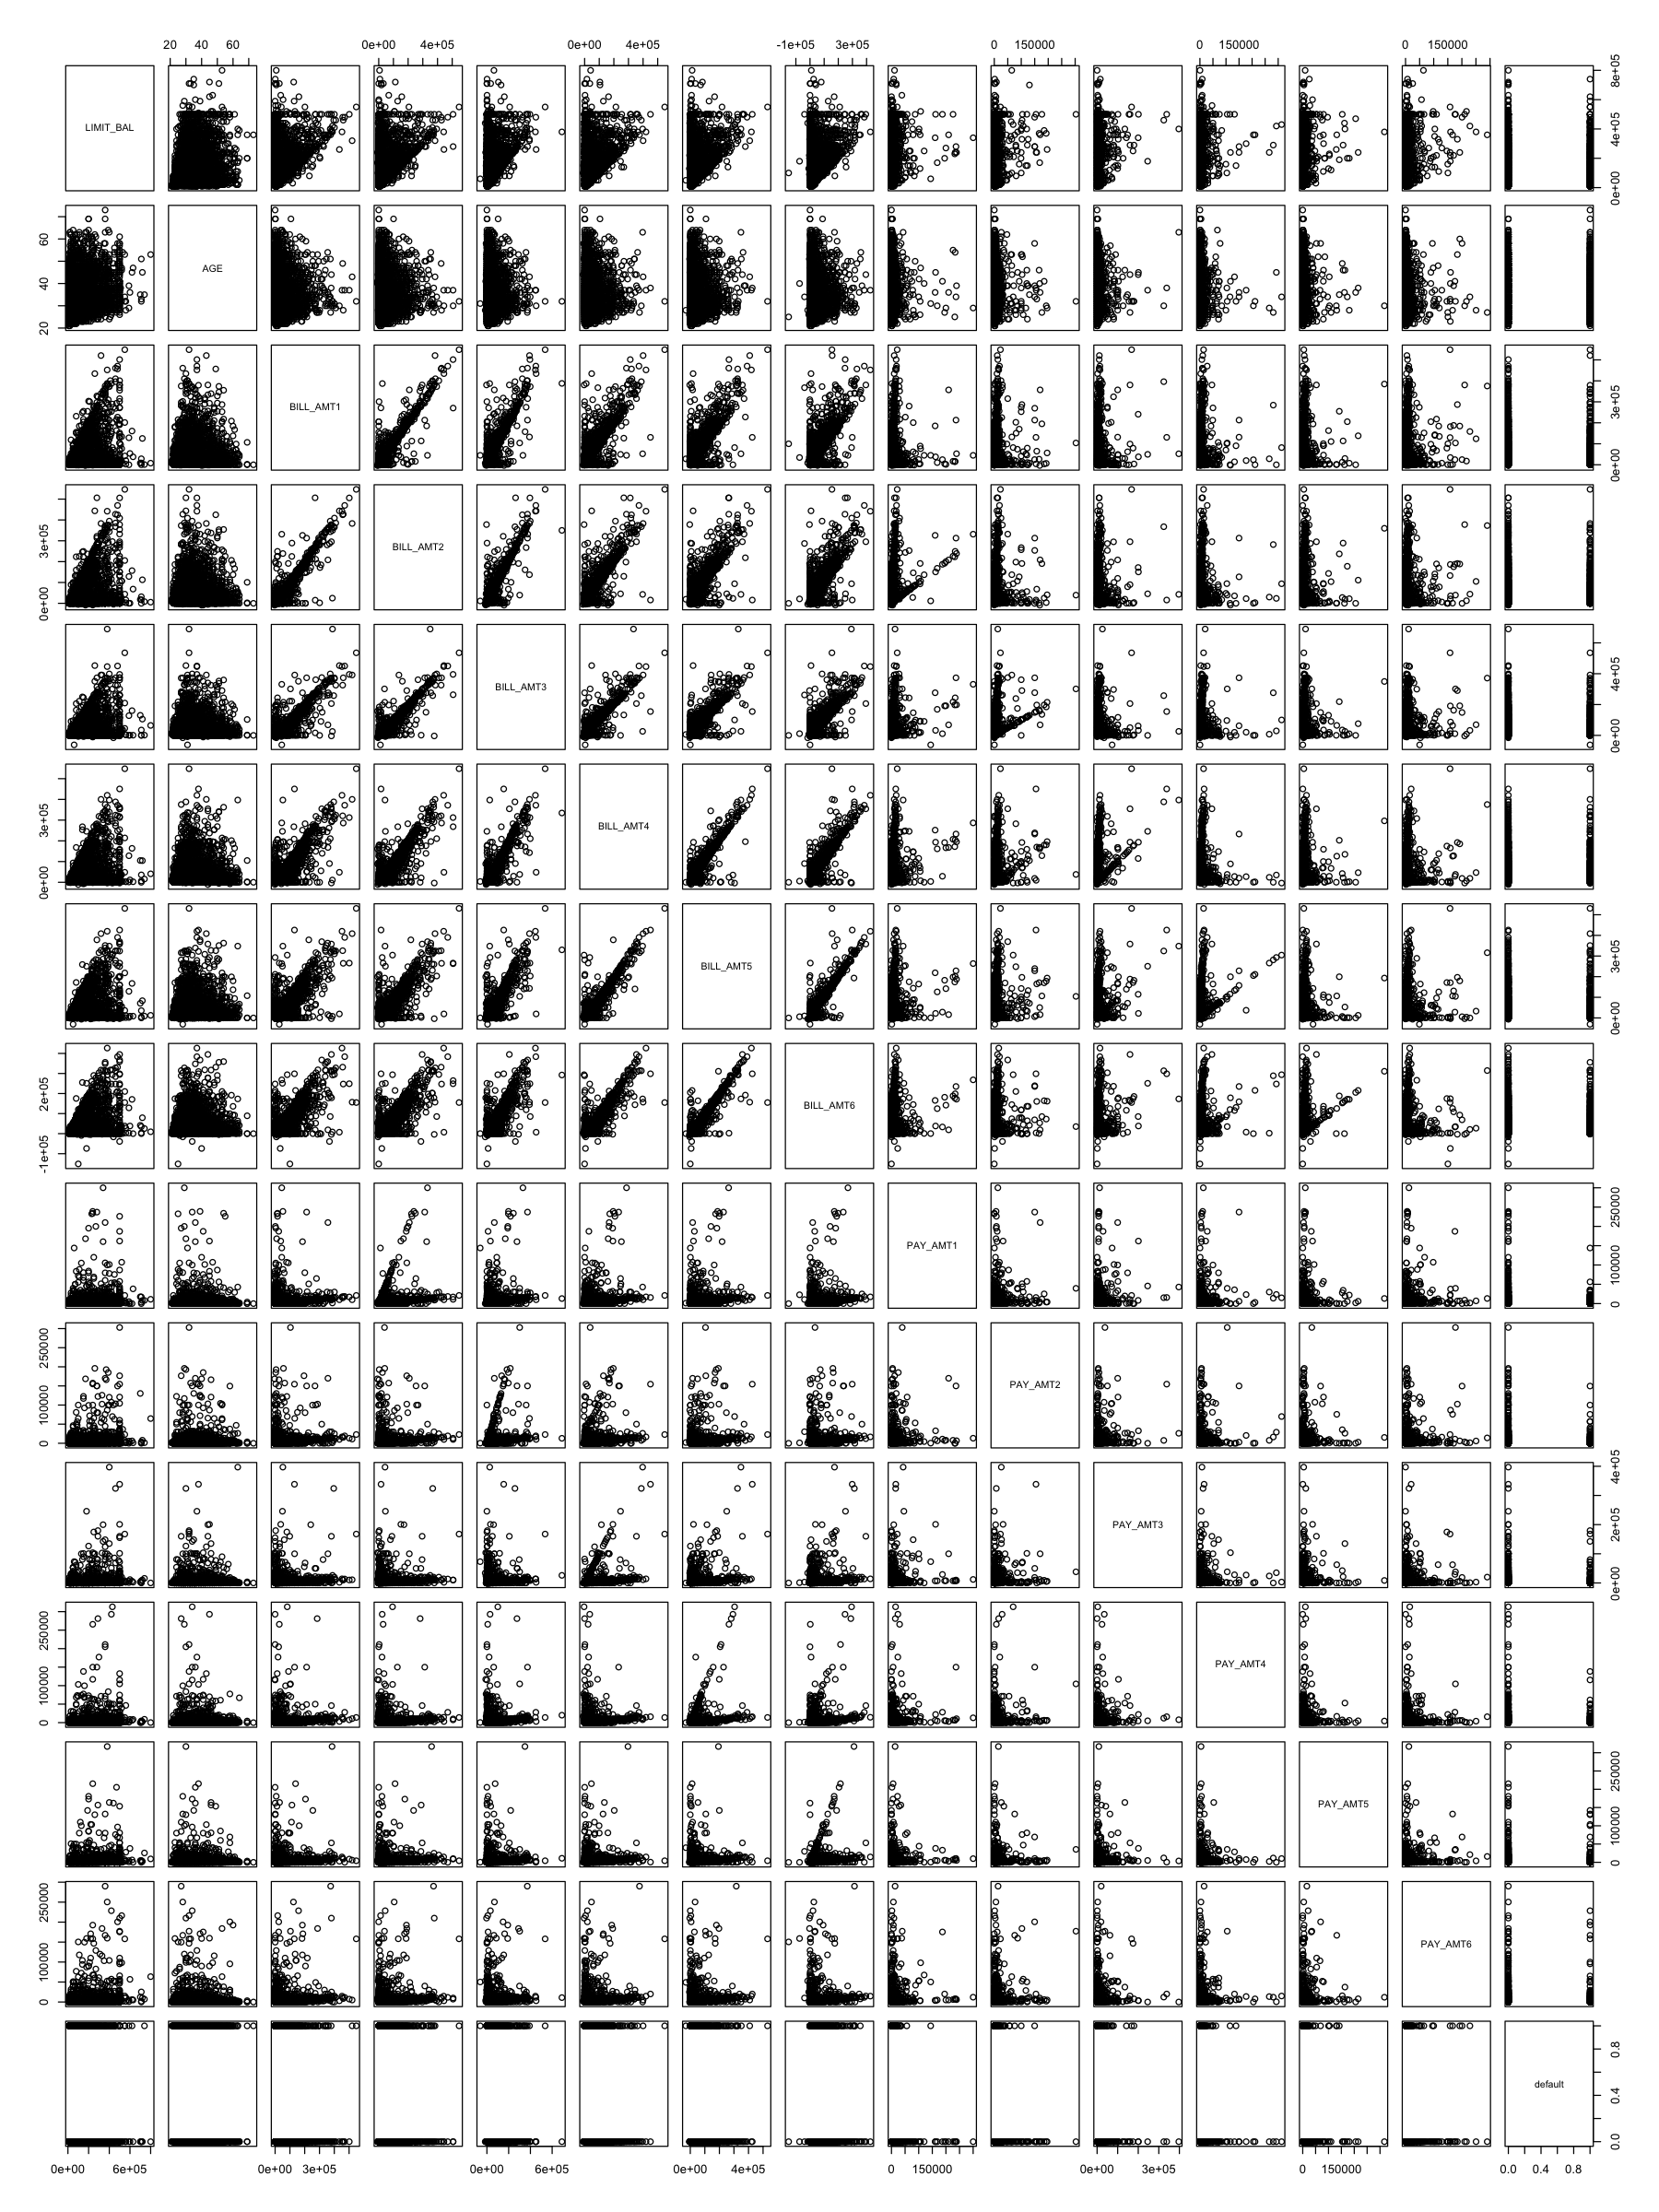

In [10]:
options(repr.plot.width=15, repr.plot.height=20)
plot(credit.sample[, credit.numericCols])

--> Box Plots:

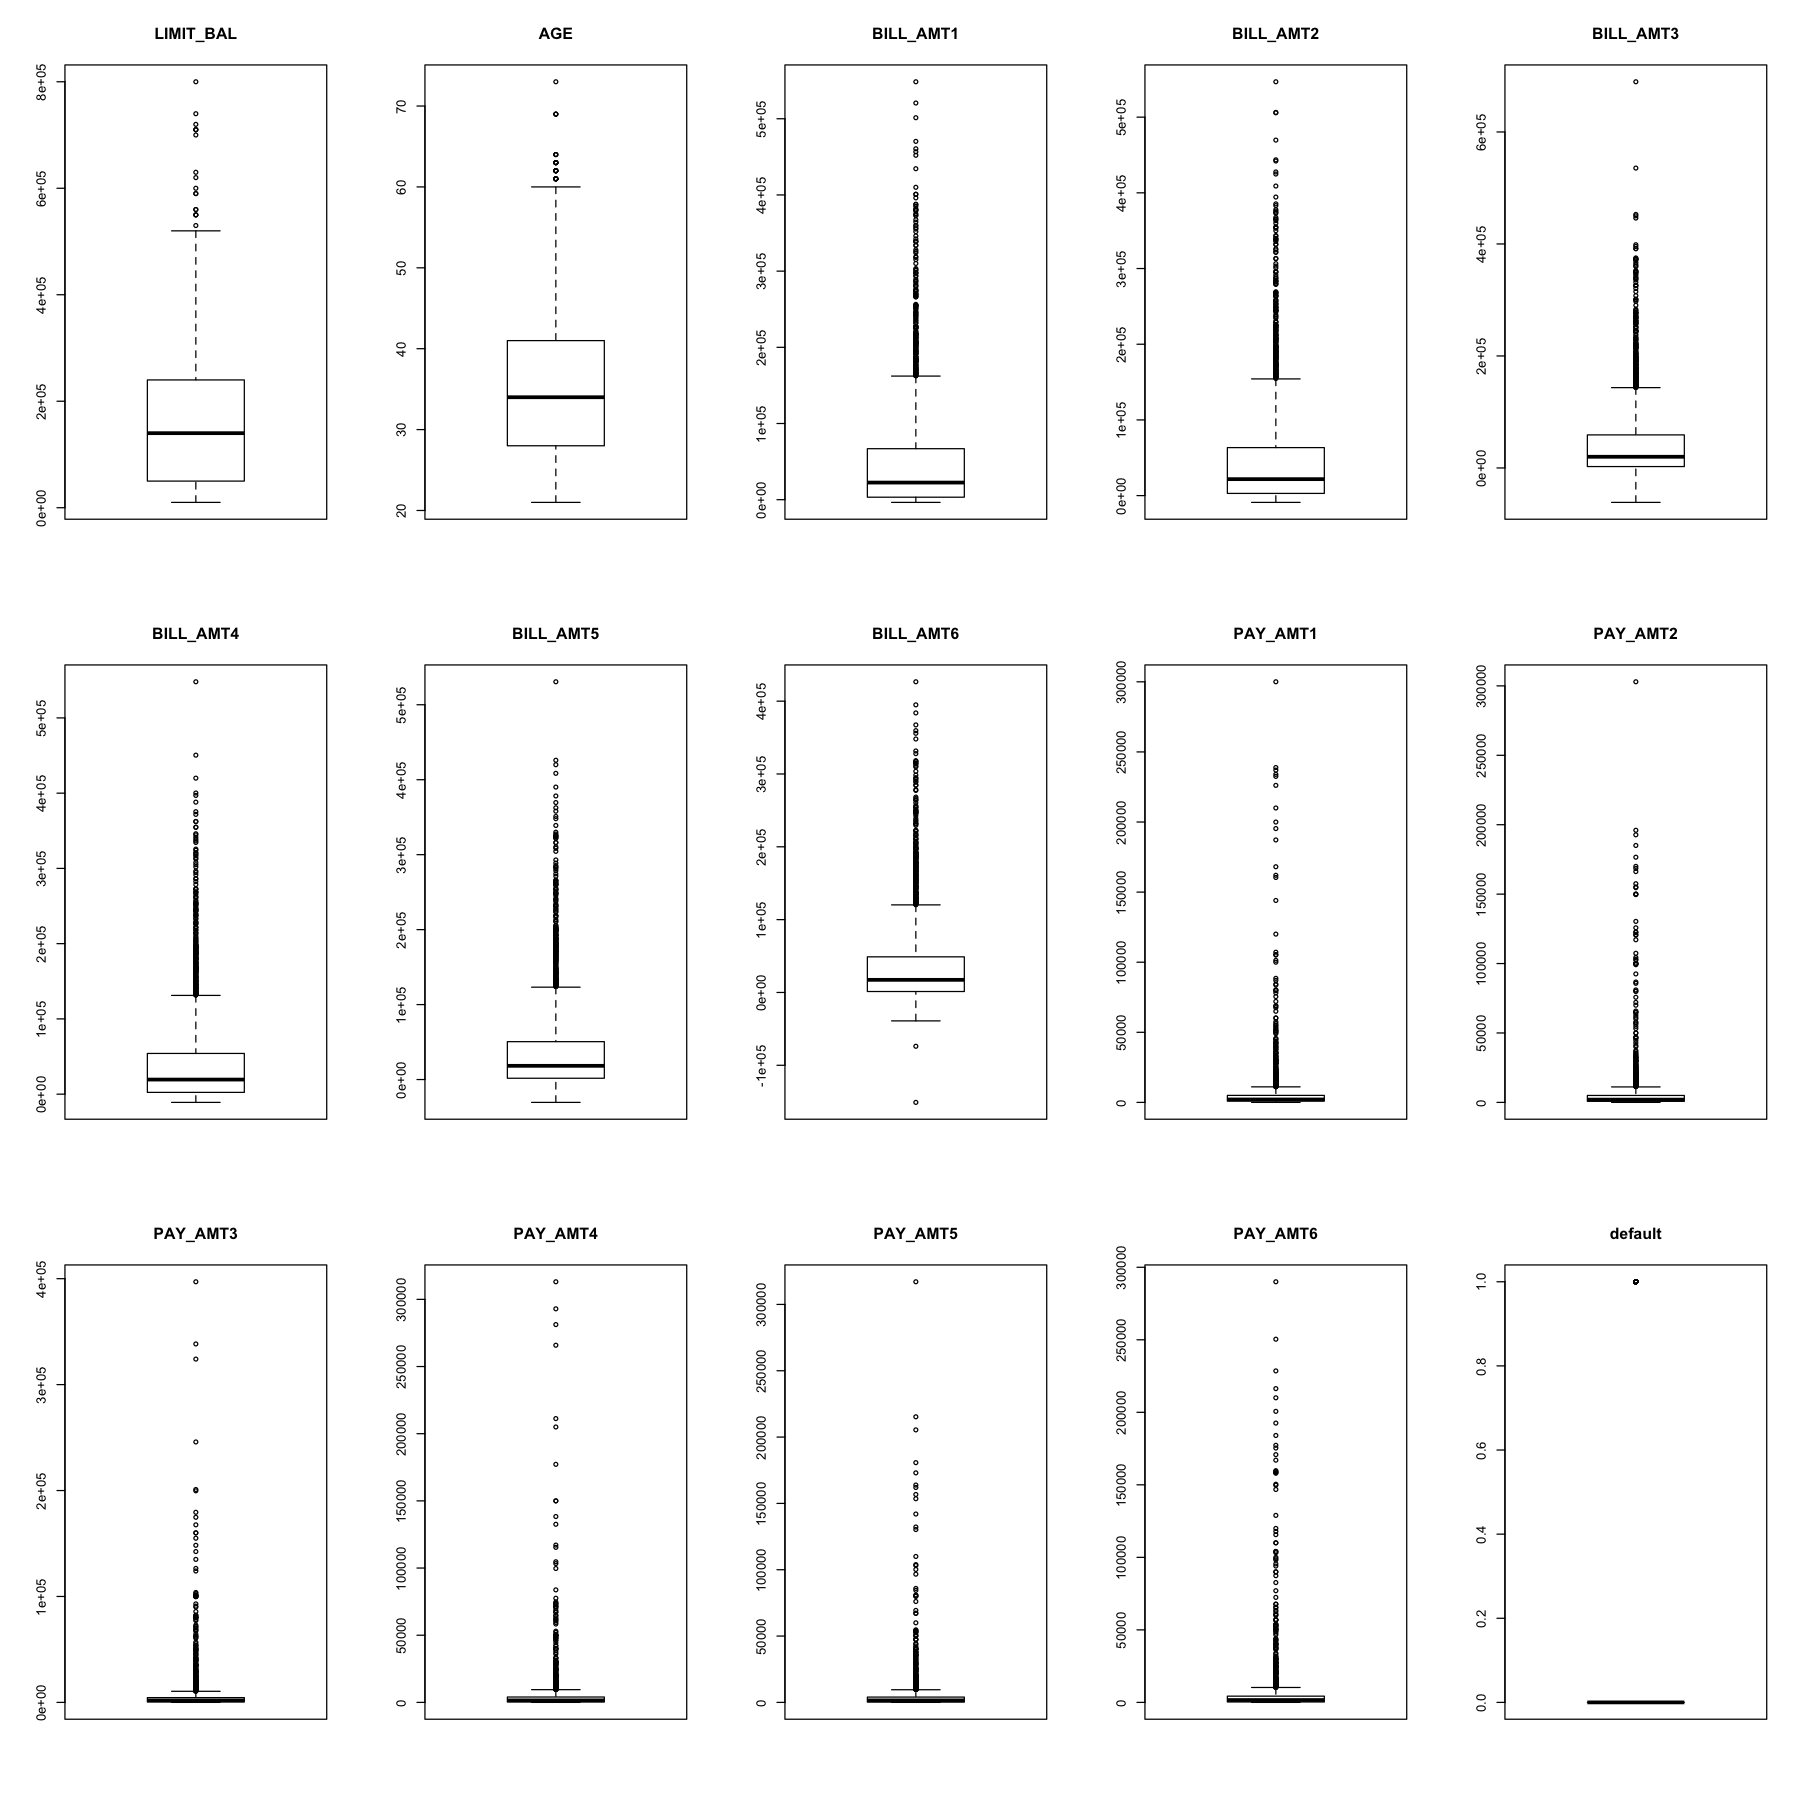

In [22]:
# dev.off()

options(repr.plot.width=15, repr.plot.height=15)
par(mfrow=c(3,5))
crearteBoxPlots <- function (column_name, dataIN){
#     print (column_name)
#     print (nrow(dataIN))
    boxplot(dataIN[column_name], horizontal = FALSE,  main= column_name)
#     stripchart(dataIN[column_name], add = TRUE, pch = 20, col = 'red')
} 
a <- sapply(credit.numericCols, FUN=crearteBoxPlots, dataIN=credit.sample)

--> Histograms for Numerical columns:

Using  as id variables


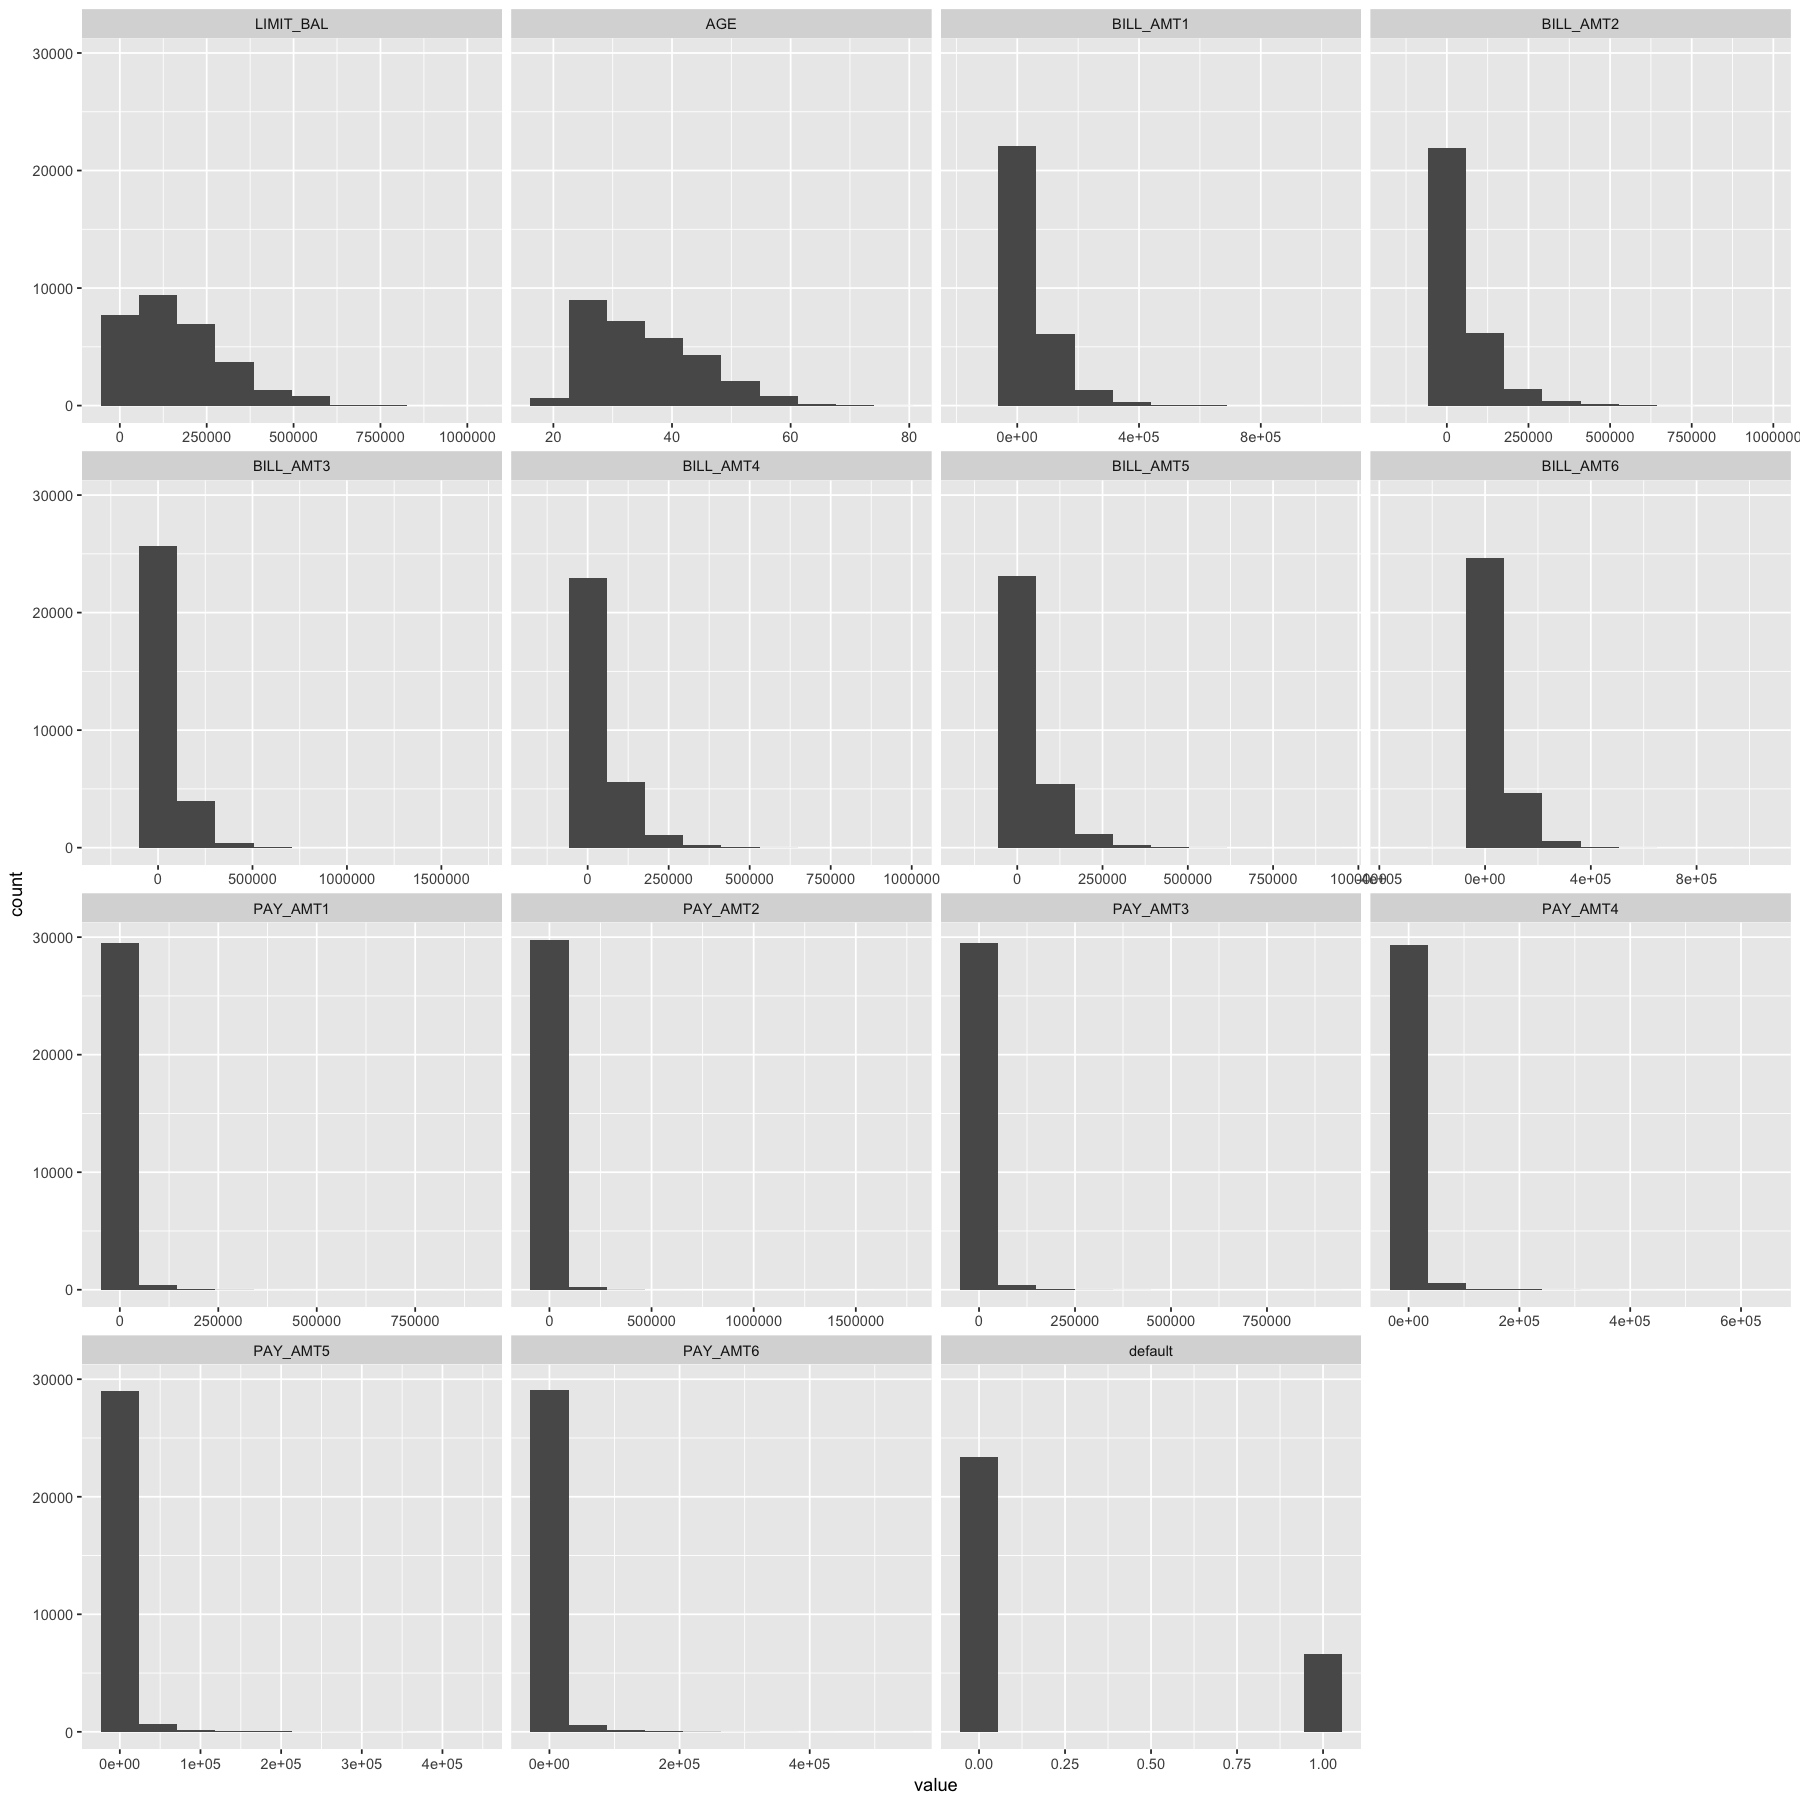

In [27]:
ggplot(data = melt(credit.data[, credit.numericCols]), mapping = aes(x = value)) + 
        geom_histogram(bins = 10) + facet_wrap(~variable, scales = 'free_x')

###  v. Build a logistic regression model to determine whether or not a customer defaulted. Use all of the variables. Validate the model on a test data set. Use the comments to discuss the performance of the model.

In [36]:
# credit.featureModel1 <- bindModel(yLabel = 'default',xFeatures = c(credit.numericCols, credit.nominalCols))
# credit.featureModel1
# str(credit.data)
dataOUT <- stratifiedSampling(dataIN=credit.data, sample_on_col='default', trainPrcnt = 0.8)

credit.trainData <- dataOUT[[1]]
credit.testData <- dataOUT[[2]]

In [37]:
str(credit.trainData)

'data.frame':	24000 obs. of  24 variables:
 $ LIMIT_BAL: int  20000 120000 90000 50000 50000 50000 100000 140000 20000 200000 ...
 $ SEX      : Factor w/ 2 levels "1","2": 2 2 2 2 1 1 2 2 1 2 ...
 $ EDUCATION: Factor w/ 7 levels "0","1","2","3",..: 3 3 3 3 3 2 3 4 4 4 ...
 $ MARRIAGE : Factor w/ 4 levels "0","1","2","3": 2 3 3 2 2 3 3 2 3 3 ...
 $ AGE      : int  24 26 34 37 57 37 23 28 35 34 ...
 $ PAY_0    : Factor w/ 11 levels "-1","-2","0",..: 5 1 3 3 1 3 3 3 2 3 ...
 $ PAY_2    : Factor w/ 11 levels "-1","-2","0",..: 5 5 3 3 3 3 1 3 2 3 ...
 $ PAY_3    : Factor w/ 11 levels "-1","-2","0",..: 1 3 3 3 1 3 1 5 2 5 ...
 $ PAY_4    : Factor w/ 11 levels "-1","-2","0",..: 1 3 3 3 3 3 3 3 2 3 ...
 $ PAY_5    : Factor w/ 10 levels "-1","-2","0",..: 2 3 3 3 3 3 3 3 1 3 ...
 $ PAY_6    : Factor w/ 10 levels "-1","-2","0",..: 2 4 3 3 3 3 1 3 1 1 ...
 $ BILL_AMT1: int  3913 2682 29239 46990 8617 64400 11876 11285 0 11073 ...
 $ BILL_AMT2: int  3102 1725 14027 48233 5670 57069 380 14096 0 9787